# **Machine Learning Project**
## Neural Networks
For this project I will use a Convolutional Neural Netwrok, typically used for image detection and classification.

Here you can find explanations of some used functions
https://www.tensorflow.org/tutorials/images/cnn

# 1. Importing libraries

In [1]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [2]:
! pip install -q kaggle

In [3]:
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import keras_tuner as kt
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pickle

In [5]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
print(tf.__version__)

2.15.0


In [6]:
# Set seed value
seed_value = 56
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)

# Set random seed for NumPy
np.random.seed(seed_value)

# Set random seed for TensorFlow
tf.random.set_seed(seed_value)

# 2. Load data

In [ ]:
from google.colab import files

files.upload() # upload your kaggle api key

In [8]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification

100% 473M/474M [00:07<00:00, 58.0MB/s]
100% 474M/474M [00:07<00:00, 70.8MB/s]


In [11]:
!unzip -q ./muffin-vs-chihuahua-image-classification.zip -d .

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [13]:
# Define the paths to the train and test directories
train_dir = '/content/train'
test_dir = '/content/test'

# Define image dimensions and batch size
img_height, img_width = 100, 100
batch_size = 32
color_mode='rgb'

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=56,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode= color_mode)

Found 4733 files belonging to 2 classes.


In [15]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=56,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False,
  color_mode= color_mode)

Found 1184 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['chihuahua', 'muffin']


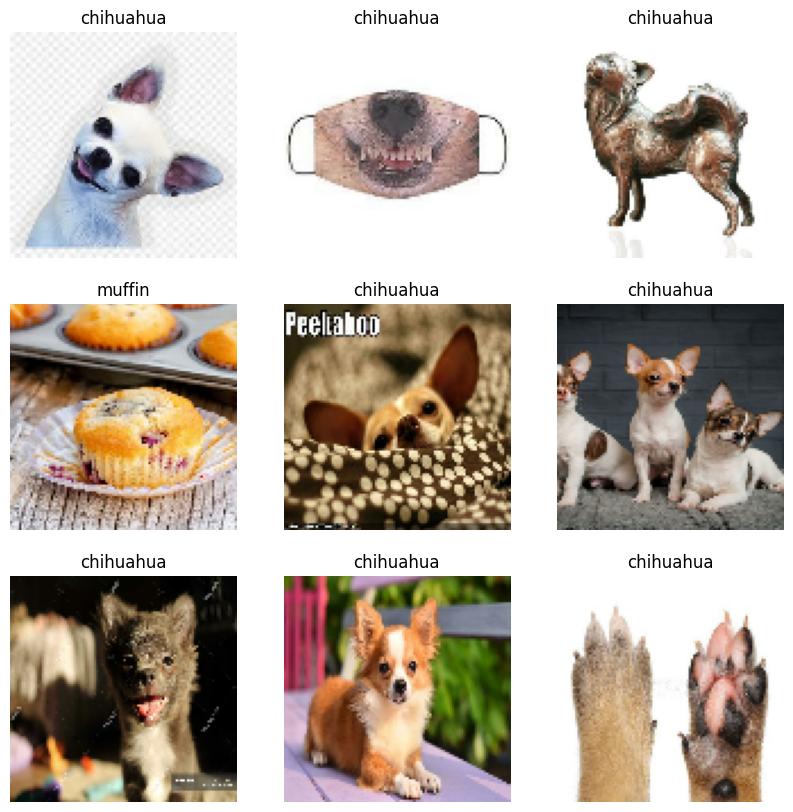

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_index = int(labels[i])
    plt.title(class_names[label_index])
    plt.axis('off')

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 100, 100, 3)
(32,)


## Loading functions

In [16]:
from utilities import *

# 3. Data preprocessing

In [17]:
train_images, train_labels = preprocess_train_dataset(train_ds)
test_images, test_labels = preprocess_test_dataset(test_ds)

In [18]:
train_images.shape

(4733, 100, 100, 1)

In [19]:
train_labels.shape

(4733,)

In [20]:
test_images.shape

(1184, 100, 100, 1)

In [21]:
test_labels.shape

(1184,)

In [22]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=56)

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels).reshape(-1, 1)

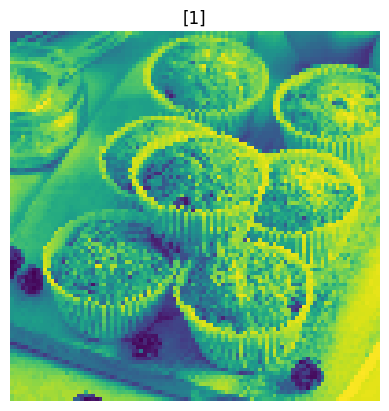

In [ ]:
# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0
val_images = val_images / 255.0

# Display the scaled down and transformed image
plt.imshow(train_images[3])
plt.title(train_labels[3]) # 0 for chihuahua, 1 for muffin
plt.axis('off')
plt.show()

In [ ]:
print(np.min(train_images[3]), np.max(train_images[3]))

0.05842015 0.9971401


## Basic Model

We build a sequential model and add convolutional layers and max pooling layers to it.

### Training of the Basic Model

In [ ]:
with tf.device(device_name):
  model = basic_model()
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 49, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 32)       

In [ ]:
history = model.fit(train_images, train_labels, batch_size = batch_size, epochs=25, validation_data = (val_images, val_labels))

Epoch 1/25
119/119 [==============================] - 7s 21ms/step - loss: 0.6185 - accuracy: 0.6450 - val_loss: 0.5468 - val_accuracy: 0.7307
Epoch 2/25
119/119 [==============================] - 2s 15ms/step - loss: 0.4894 - accuracy: 0.7731 - val_loss: 0.4629 - val_accuracy: 0.7983
Epoch 3/25
119/119 [==============================] - 2s 16ms/step - loss: 0.4606 - accuracy: 0.7924 - val_loss: 0.4508 - val_accuracy: 0.7973
Epoch 4/25
119/119 [==============================] - 2s 18ms/step - loss: 0.3871 - accuracy: 0.8262 - val_loss: 0.5393 - val_accuracy: 0.7719
Epoch 5/25
119/119 [==============================] - 2s 16ms/step - loss: 0.3623 - accuracy: 0.8442 - val_loss: 0.3837 - val_accuracy: 0.8289
Epoch 6/25
119/119 [==============================] - 2s 14ms/step - loss: 0.3104 - accuracy: 0.8706 - val_loss: 0.3602 - val_accuracy: 0.8374
Epoch 7/25
119/119 [==============================] - 2s 14ms/step - loss: 0.2639 - accuracy: 0.8891 - val_loss: 0.4551 - val_accuracy: 0.8120

As we can see here the loss is very small which indicates that there is overfitting.

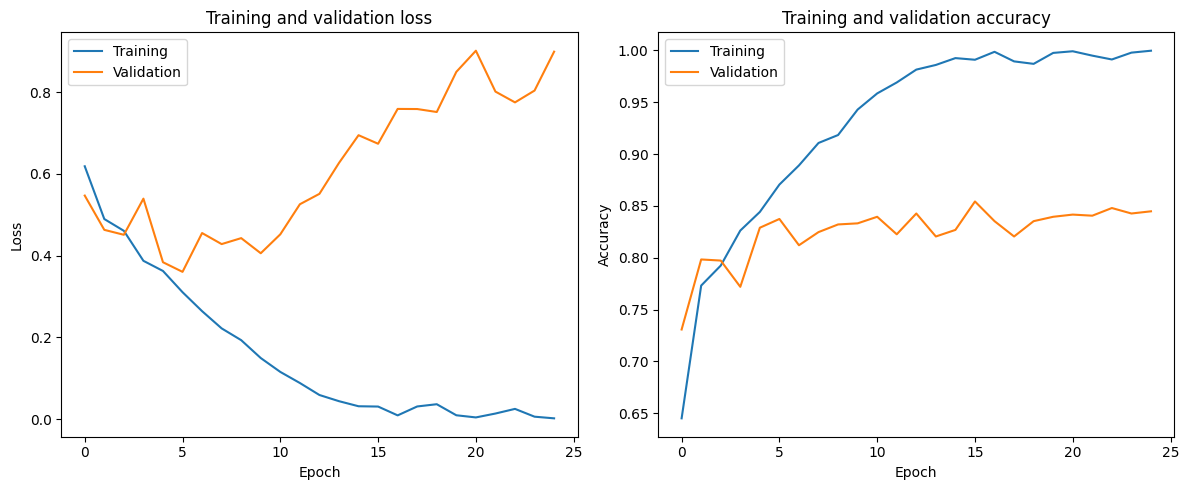

In [ ]:
performance(history)

Could come from the learning rate being too high, from the presence of noise meaning that it some batches could contain outliers so the model struggles to generalise at first but then it stabilizes, or just that the model could be sensitive to the initialisation parameters but it becomes more stable as training progresses.

Let us experiment with different architectural changes: adding or removing layers. The model is considered to be complex since there is a high number of layers, non-linear activation functions and a large number of neurons. So, firstly we try to remove a layer and see how the model behaves.

In [ ]:
with tf.device(device_name):
  model1 = basic_model(remove_layer=True)
  model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 49, 49, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 21, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 10, 10, 32)       

In [ ]:
history_1 = model1.fit(train_images, train_labels, batch_size = batch_size, epochs=30, validation_data = (val_images, val_labels))

Epoch 1/30
119/119 [==============================] - 3s 16ms/step - loss: 0.6181 - accuracy: 0.6503 - val_loss: 0.5326 - val_accuracy: 0.7423
Epoch 2/30
119/119 [==============================] - 2s 14ms/step - loss: 0.4958 - accuracy: 0.7726 - val_loss: 0.4691 - val_accuracy: 0.7846
Epoch 3/30
119/119 [==============================] - 2s 14ms/step - loss: 0.4590 - accuracy: 0.7929 - val_loss: 0.4452 - val_accuracy: 0.7983
Epoch 4/30
119/119 [==============================] - 2s 15ms/step - loss: 0.4018 - accuracy: 0.8214 - val_loss: 0.4871 - val_accuracy: 0.8004
Epoch 5/30
119/119 [==============================] - 2s 17ms/step - loss: 0.3789 - accuracy: 0.8349 - val_loss: 0.3950 - val_accuracy: 0.8226
Epoch 6/30
119/119 [==============================] - 2s 14ms/step - loss: 0.3393 - accuracy: 0.8500 - val_loss: 0.3774 - val_accuracy: 0.8437
Epoch 7/30
119/119 [==============================] - 2s 14ms/step - loss: 0.3132 - accuracy: 0.8658 - val_loss: 0.4549 - val_accuracy: 0.8089

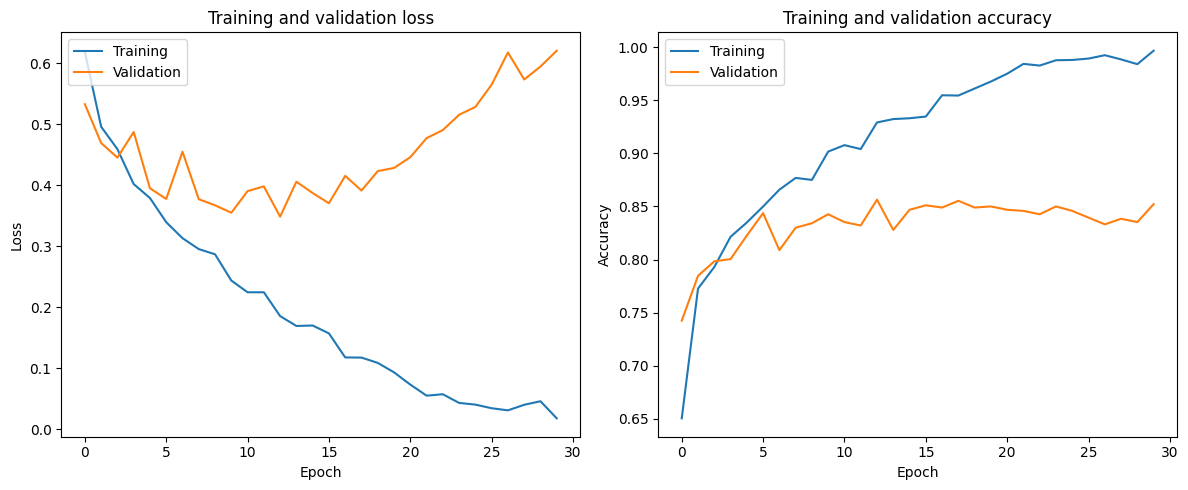

In [ ]:
performance(history_1)

Comparing with the previous output, we observe that although the training accuracy is slightly lower, the validation accuracy has improved. This indicates that removing the dense layer may have helped to reduce overfitting, as the model is now performing better on unseen validation data. However, further analysis and experimentation might be needed to optimize the model's architecture and hyperparameters for better performance.

Let us try to fix this by adding a Dropout layer.

In [ ]:
with tf.device(device_name):
  model2 = drop_model(dropout_rate = 0.5)
  model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 49, 49, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 21, 32)        18464     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 10, 10, 32)       

In [ ]:
history_2 = model2.fit(train_images, train_labels, batch_size = batch_size, epochs=30, validation_data = (val_images, val_labels))

Epoch 1/30
119/119 [==============================] - 5s 17ms/step - loss: 0.6089 - accuracy: 0.6643 - val_loss: 0.5057 - val_accuracy: 0.7455
Epoch 2/30
119/119 [==============================] - 2s 17ms/step - loss: 0.4723 - accuracy: 0.7842 - val_loss: 0.4345 - val_accuracy: 0.8078
Epoch 3/30
119/119 [==============================] - 2s 16ms/step - loss: 0.4465 - accuracy: 0.7993 - val_loss: 0.4146 - val_accuracy: 0.8131
Epoch 4/30
119/119 [==============================] - 2s 14ms/step - loss: 0.3888 - accuracy: 0.8259 - val_loss: 0.3996 - val_accuracy: 0.8163
Epoch 5/30
119/119 [==============================] - 2s 14ms/step - loss: 0.3500 - accuracy: 0.8518 - val_loss: 0.3827 - val_accuracy: 0.8310
Epoch 6/30
119/119 [==============================] - 2s 14ms/step - loss: 0.3021 - accuracy: 0.8666 - val_loss: 0.3487 - val_accuracy: 0.8522
Epoch 7/30
119/119 [==============================] - 2s 15ms/step - loss: 0.2682 - accuracy: 0.8872 - val_loss: 0.3444 - val_accuracy: 0.8543

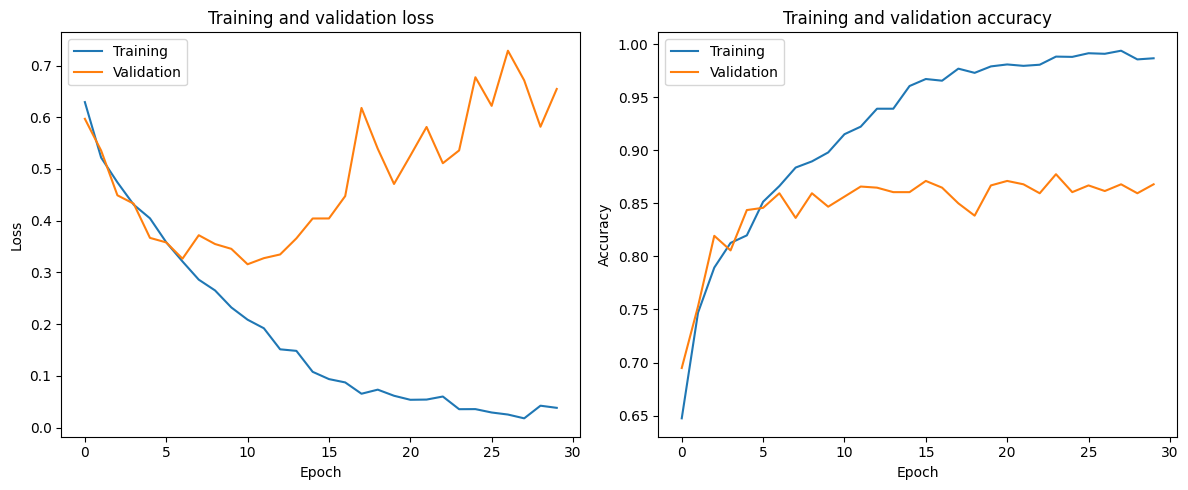

In [ ]:
performance(history_2)

Adding a dropout layer to the model appears to have led to a decrease in training accuracy compared to the previous outputs, indicating that the model is now less prone to overfitting. However, the validation accuracy has also decreased slightly, suggesting that there might still be room for improvement in the model's generalization performance.

Let us increase the dropout probability and add another layer instead.

In [ ]:
model3 = Sequential([
    tf.keras.layers.InputLayer(input_shape=(100, 100, 1)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    Dropout(0.7),  # Dropout layer with dropout rate of 0.7
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
with tf.device(device_name):
  model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model3.summary()

In [ ]:
history_3 = model3.fit(train_images, train_labels, batch_size = batch_size, epochs=35, validation_data = (val_images, val_labels))

Epoch 1/35
119/119 [==============================] - 4s 18ms/step - loss: 0.6905 - accuracy: 0.5322 - val_loss: 0.6685 - val_accuracy: 0.5512
Epoch 2/35
119/119 [==============================] - 2s 15ms/step - loss: 0.6126 - accuracy: 0.6952 - val_loss: 0.5462 - val_accuracy: 0.7434
Epoch 3/35
119/119 [==============================] - 2s 17ms/step - loss: 0.5155 - accuracy: 0.7771 - val_loss: 0.4689 - val_accuracy: 0.7687
Epoch 4/35
119/119 [==============================] - 2s 16ms/step - loss: 0.4700 - accuracy: 0.8114 - val_loss: 0.4786 - val_accuracy: 0.7782
Epoch 5/35
119/119 [==============================] - 2s 14ms/step - loss: 0.4334 - accuracy: 0.8151 - val_loss: 0.4391 - val_accuracy: 0.7994
Epoch 6/35
119/119 [==============================] - 2s 15ms/step - loss: 0.4019 - accuracy: 0.8431 - val_loss: 0.4016 - val_accuracy: 0.8141
Epoch 7/35
119/119 [==============================] - 2s 15ms/step - loss: 0.3503 - accuracy: 0.8603 - val_loss: 0.4076 - val_accuracy: 0.8163

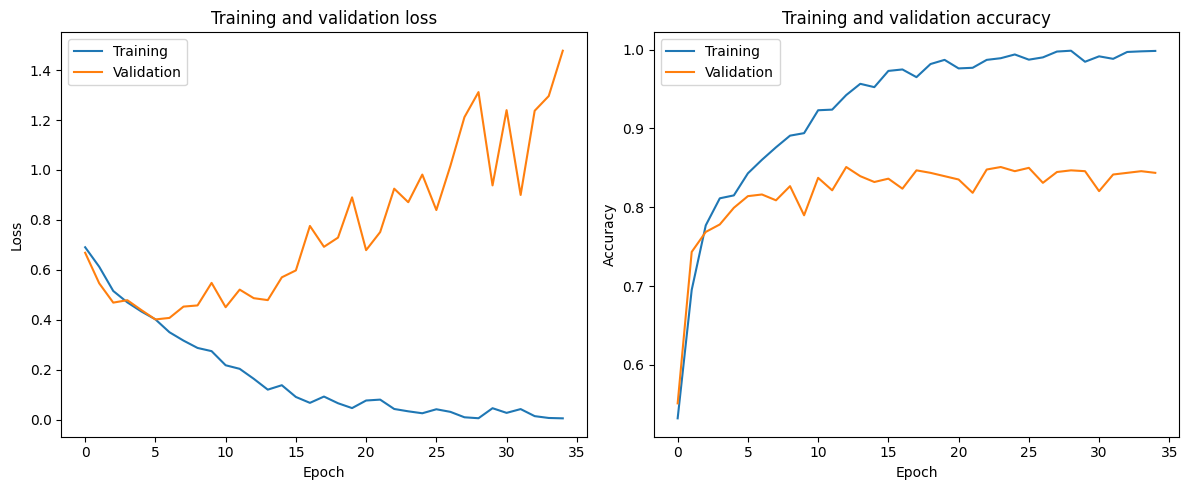

In [ ]:
performance(history_3)

Increasing the dropout probability and adding another dense layer may have improved the model's generalization ability, as evidenced by the relatively stable training accuracy and the validation accuracy hovering around 84%. However, the validation loss has increased significantly, suggesting that the model may be overfitting to the training data. Further fine-tuning of hyperparameters and possibly adjusting the model architecture may be necessary to achieve better validation performance.

We increased the dropout rate at 0.7, which is already quite high, so further increasing it might not be ideal, but since the model appears to be quite complex we are going to reduce the number of layers and neurons to simplify it.

In [ ]:
model4 = Sequential([
    tf.keras.layers.InputLayer(input_shape=(100, 100, 1)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
with tf.device(device_name):
  model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 10, 10, 32)      

In [ ]:
history_4 = model4.fit(train_images, train_labels, batch_size = batch_size, epochs=30, validation_data = (val_images, val_labels))

Epoch 1/30
119/119 [==============================] - 4s 14ms/step - loss: 0.6938 - accuracy: 0.5333 - val_loss: 0.6954 - val_accuracy: 0.4498
Epoch 2/30
119/119 [==============================] - 1s 9ms/step - loss: 0.6920 - accuracy: 0.5354 - val_loss: 0.6879 - val_accuracy: 0.5533
Epoch 3/30
119/119 [==============================] - 1s 11ms/step - loss: 0.6837 - accuracy: 0.5417 - val_loss: 0.6653 - val_accuracy: 0.5924
Epoch 4/30
119/119 [==============================] - 1s 11ms/step - loss: 0.6007 - accuracy: 0.6793 - val_loss: 0.5317 - val_accuracy: 0.7571
Epoch 5/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5291 - accuracy: 0.7565 - val_loss: 0.4829 - val_accuracy: 0.7920
Epoch 6/30
119/119 [==============================] - 1s 9ms/step - loss: 0.4713 - accuracy: 0.7942 - val_loss: 0.4321 - val_accuracy: 0.8173
Epoch 7/30
119/119 [==============================] - 1s 9ms/step - loss: 0.4468 - accuracy: 0.8056 - val_loss: 0.4730 - val_accuracy: 0.7878
Ep

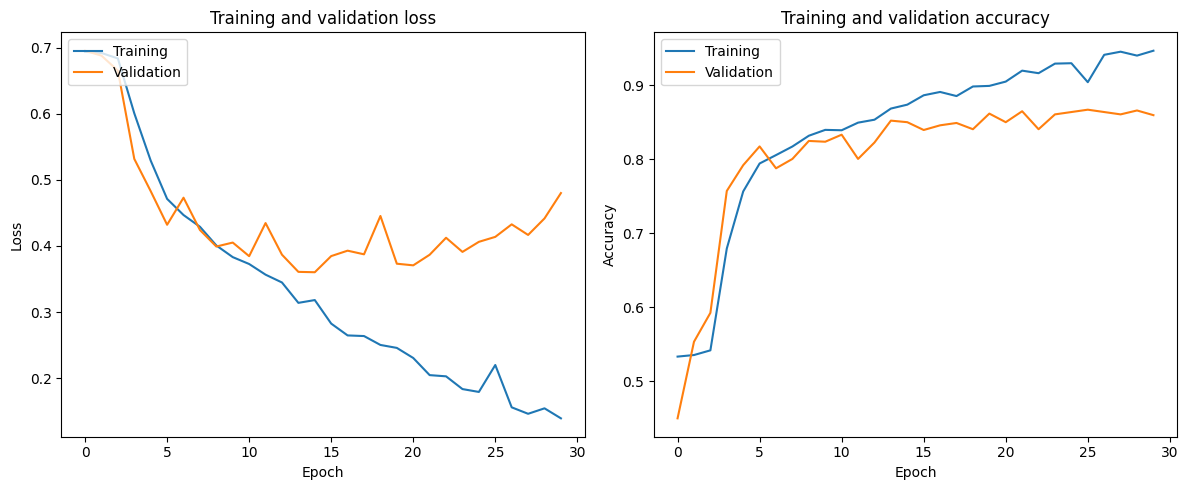

In [ ]:
performance(history_4)

Way better than before! In this case, the model achieved a training accuracy of around 94.66% and a validation accuracy of around 85.96%. The validation accuracy is higher than the previous examples, indicating improved generalization performance. The validation loss is also relatively low, suggesting that the model is performing well on unseen data. Overall, this seems to be a good result, indicating that the model is learning effectively and generalizing well to the validation dataset. Let us try to improve it and see if we can reduce more overfitting with regularization.

### L2 Regularization

In [ ]:
model5 = second_model()

In [ ]:
with tf.device(device_name):
  model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 32)        0

In [ ]:
history_5 = model5.fit(train_images, train_labels, batch_size = batch_size, epochs=30, validation_data = (val_images, val_labels))

Epoch 1/30
119/119 [==============================] - 3s 13ms/step - loss: 0.7239 - accuracy: 0.5481 - val_loss: 0.6706 - val_accuracy: 0.6864
Epoch 2/30
119/119 [==============================] - 1s 10ms/step - loss: 0.6325 - accuracy: 0.6556 - val_loss: 0.5467 - val_accuracy: 0.7614
Epoch 3/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5619 - accuracy: 0.7475 - val_loss: 0.5414 - val_accuracy: 0.7561
Epoch 4/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5481 - accuracy: 0.7538 - val_loss: 0.5224 - val_accuracy: 0.7687
Epoch 5/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5238 - accuracy: 0.7639 - val_loss: 0.5030 - val_accuracy: 0.7592
Epoch 6/30
119/119 [==============================] - 1s 10ms/step - loss: 0.4936 - accuracy: 0.7911 - val_loss: 0.4649 - val_accuracy: 0.8184
Epoch 7/30
119/119 [==============================] - 1s 10ms/step - loss: 0.4737 - accuracy: 0.8030 - val_loss: 0.4856 - val_accuracy: 0.7920

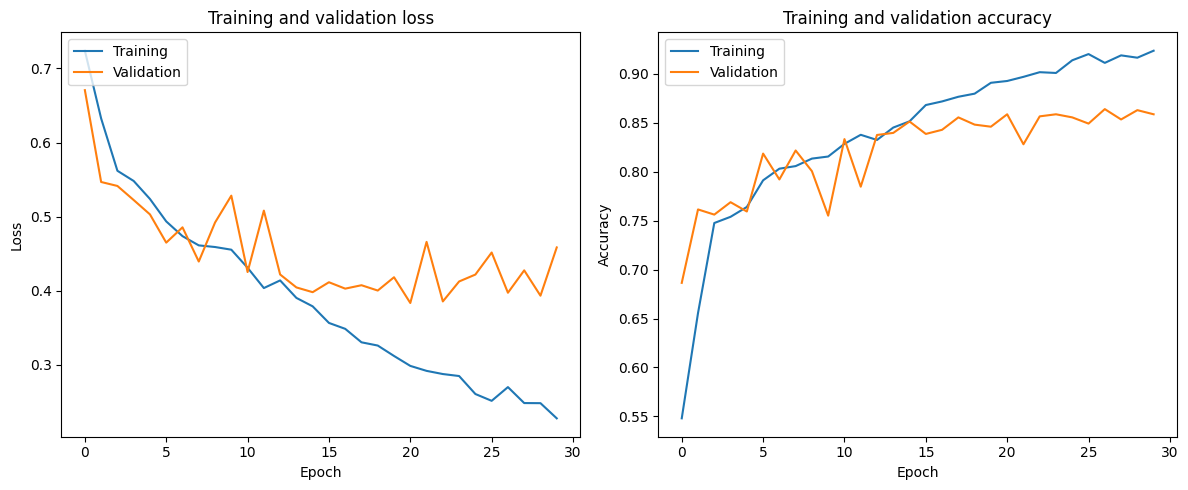

In [ ]:
performance(history_5)

L2 regularization has led to a decrease in both training and validation accuracies. While the training loss has increased, indicating that the model is learning simpler patterns, the validation loss has also decreased slightly, suggesting improved generalization. However, the validation accuracy remains relatively unchanged. It has helped to decrease overfitting but it did not improve much the generalization performance.

In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True) # it is a classification-based problem so it is better to check val accuracy

In [ ]:
model6 = second_model()
with tf.device(device_name):
  model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_6 = model6.fit(train_images, train_labels, batch_size = batch_size, epochs=30, validation_data = (val_images, val_labels), callbacks = [es])

Epoch 1/30
119/119 [==============================] - 3s 13ms/step - loss: 0.8676 - accuracy: 0.5415 - val_loss: 0.6899 - val_accuracy: 0.6927
Epoch 2/30
119/119 [==============================] - 1s 10ms/step - loss: 0.6555 - accuracy: 0.6373 - val_loss: 0.6275 - val_accuracy: 0.6990
Epoch 3/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5991 - accuracy: 0.7071 - val_loss: 0.5501 - val_accuracy: 0.7529
Epoch 4/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5708 - accuracy: 0.7393 - val_loss: 0.5382 - val_accuracy: 0.7582
Epoch 5/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5434 - accuracy: 0.7678 - val_loss: 0.4881 - val_accuracy: 0.8141
Epoch 6/30
119/119 [==============================] - 1s 10ms/step - loss: 0.5163 - accuracy: 0.7905 - val_loss: 0.4671 - val_accuracy: 0.8215
Epoch 7/30
119/119 [==============================] - 1s 9ms/step - loss: 0.5049 - accuracy: 0.8030 - val_loss: 0.4502 - val_accuracy: 0.8342


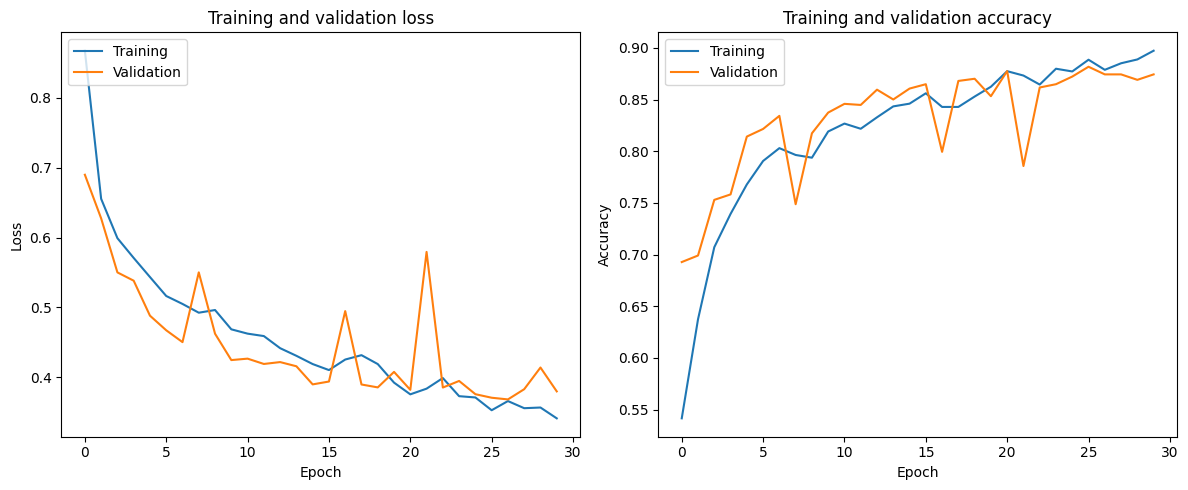

In [ ]:
performance(history_6)

What happens here, what about the bumps? They could indicate that the model performance on the validation set is unstable in its generalization

### Add Batch Normalization

In [ ]:
model7 = Sequential([
    InputLayer(input_shape=(100,100,1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.7),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

with tf.device(device_name):
  model7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_7 = model7.fit(train_images, train_labels, batch_size = batch_size, epochs=30, validation_data = (val_images, val_labels), callbacks = [es])

Epoch 1/30
119/119 [==============================] - 6s 16ms/step - loss: 0.6170 - accuracy: 0.6894 - val_loss: 0.8496 - val_accuracy: 0.6125
Epoch 2/30
119/119 [==============================] - 1s 11ms/step - loss: 0.4827 - accuracy: 0.7937 - val_loss: 1.3865 - val_accuracy: 0.6051
Epoch 3/30
119/119 [==============================] - 1s 11ms/step - loss: 0.4918 - accuracy: 0.7940 - val_loss: 0.5048 - val_accuracy: 0.7518
Epoch 4/30
119/119 [==============================] - 1s 11ms/step - loss: 0.4339 - accuracy: 0.8217 - val_loss: 1.2711 - val_accuracy: 0.5734
Epoch 5/30
119/119 [==============================] - 1s 11ms/step - loss: 0.3885 - accuracy: 0.8539 - val_loss: 1.8499 - val_accuracy: 0.5417
Epoch 6/30
119/119 [==============================] - 1s 11ms/step - loss: 0.3592 - accuracy: 0.8653 - val_loss: 2.0076 - val_accuracy: 0.5312
Epoch 7/30
119/119 [==============================] - 2s 13ms/step - loss: 0.3615 - accuracy: 0.8611 - val_loss: 0.9803 - val_accuracy: 0.5618

### Add padding and increase neurons in Dense

In [ ]:
model8 = Sequential([
    InputLayer(input_shape=(100,100,1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.6),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

with tf.device(device_name):
    model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_8 = model8.fit(train_images, train_labels, batch_size = batch_size, epochs=30, validation_data = (val_images, val_labels), callbacks = [es])

Epoch 1/30
119/119 [==============================] - 4s 14ms/step - loss: 0.8078 - accuracy: 0.7451 - val_loss: 0.9570 - val_accuracy: 0.6737
Epoch 2/30
119/119 [==============================] - 1s 12ms/step - loss: 0.6584 - accuracy: 0.8246 - val_loss: 0.6374 - val_accuracy: 0.8374
Epoch 3/30
119/119 [==============================] - 2s 13ms/step - loss: 0.6065 - accuracy: 0.8413 - val_loss: 0.6933 - val_accuracy: 0.8342
Epoch 4/30
119/119 [==============================] - 1s 13ms/step - loss: 0.5466 - accuracy: 0.8682 - val_loss: 0.6549 - val_accuracy: 0.8332
Epoch 5/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5262 - accuracy: 0.8737 - val_loss: 0.5674 - val_accuracy: 0.8617
Epoch 6/30
119/119 [==============================] - 1s 11ms/step - loss: 0.4835 - accuracy: 0.8914 - val_loss: 0.6680 - val_accuracy: 0.8131
Epoch 7/30
119/119 [==============================] - 1s 11ms/step - loss: 0.4647 - accuracy: 0.9028 - val_loss: 0.6085 - val_accuracy: 0.8215

Epoch 1/50
119/119 [==============================] - 183s 2s/step - loss: 0.6765 - accuracy: 0.6484 - val_loss: 0.6269 - val_accuracy: 0.6800
Epoch 2/50
119/119 [==============================] - 182s 2s/step - loss: 0.5591 - accuracy: 0.7382 - val_loss: 0.5426 - val_accuracy: 0.7381
Epoch 3/50
119/119 [==============================] - 181s 2s/step - loss: 0.5057 - accuracy: 0.7731 - val_loss: 0.4850 - val_accuracy: 0.7603
Epoch 4/50
119/119 [==============================] - 196s 2s/step - loss: 0.4762 - accuracy: 0.7861 - val_loss: 0.4131 - val_accuracy: 0.8046
Epoch 5/50
119/119 [==============================] - 203s 2s/step - loss: 0.4492 - accuracy: 0.7934 - val_loss: 0.4262 - val_accuracy: 0.7941
Epoch 6/50
119/119 [==============================] - 188s 2s/step - loss: 0.4221 - accuracy: 0.8133 - val_loss: 0.3720 - val_accuracy: 0.8289
Epoch 7/50
119/119 [==============================] - 196s 2s/step - loss: 0.3880 - accuracy: 0.8312 - val_loss: 0.3670 - val_accuracy: 0.8342

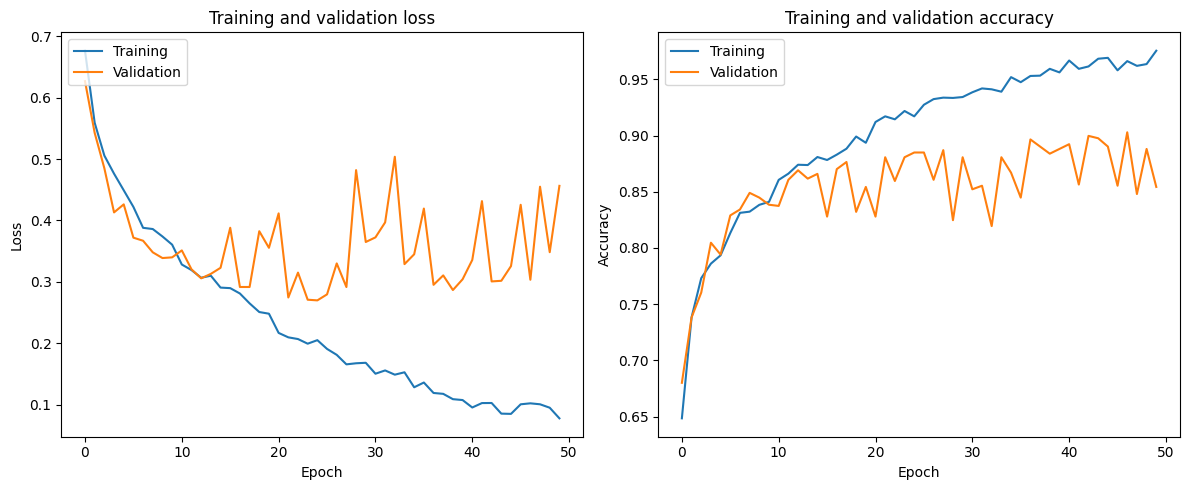

In [ ]:
with tf.device(device_name):

   model9 = Sequential([
    InputLayer(input_shape=(100,100,1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.7),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
   model9.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(0.0001),metrics=['accuracy'])
   history_9 = model9.fit(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[es])

performance(history_9)

## Hyperparameter tuning

### Optimization of the convolutional layers nodes

In [ ]:
layer_nodes = [128, 64, 32]

best_accuracy = 0
best_params = {}

with tf.device(device_name):
    for l1 in layer_nodes:
        for l2 in layer_nodes:
          for l3 in layer_nodes:
            model = Sequential([
    InputLayer(input_shape=(100,100,1)),
    Conv2D(l1, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(l2, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(l3, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.7),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

            optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

            # Train the model
            history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels), verbose=0)

            val_accuracy = history.history['val_accuracy'][-1]

            # Print the results
            print(f'Layer Sizes: {l1}, {l2}, {l3}, Validation Accuracy: {val_accuracy}')

            # Update best parameters if this configuration has higher validation accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'layer1_size': l1, 'layer2_size': l2, 'layer3_size': l3}

print(f'Best parameters: {best_params}, Best validation accuracy: {best_accuracy}')

Layer Sizes: 128, 128, 128, Validation Accuracy: 0.8713080286979675
Layer Sizes: 128, 128, 64, Validation Accuracy: 0.6160337328910828
Layer Sizes: 128, 128, 32, Validation Accuracy: 0.8565400838851929
Layer Sizes: 128, 64, 128, Validation Accuracy: 0.8565400838851929
Layer Sizes: 128, 64, 64, Validation Accuracy: 0.8417721390724182
Layer Sizes: 128, 64, 32, Validation Accuracy: 0.8122363090515137
Layer Sizes: 128, 32, 128, Validation Accuracy: 0.8607594966888428
Layer Sizes: 128, 32, 64, Validation Accuracy: 0.5991561412811279
Layer Sizes: 128, 32, 32, Validation Accuracy: 0.8438818454742432
Layer Sizes: 64, 128, 128, Validation Accuracy: 0.5042194128036499
Layer Sizes: 64, 128, 64, Validation Accuracy: 0.6940928101539612
Layer Sizes: 64, 128, 32, Validation Accuracy: 0.850210964679718
Layer Sizes: 64, 64, 128, Validation Accuracy: 0.7616033554077148
Layer Sizes: 64, 64, 64, Validation Accuracy: 0.8417721390724182
Layer Sizes: 64, 64, 32, Validation Accuracy: 0.5780590772628784
Layer 

### Optimization of Learning Rate

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
best_accuracy = 0
best_learning_rate = None


for lr in learning_rates:
    model = Sequential([
    InputLayer(input_shape=(100,100,1)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.7),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels), verbose=0)

    val_accuracy = history.history['val_accuracy'][-1]

    print(f'Learning Rate: {lr}, Validation Accuracy: {val_accuracy}')

    # Update best learning rate if this one has higher validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_learning_rate = lr

print(f'Best learning rate: {best_learning_rate}, Best validation accuracy: {best_accuracy}')


Learning Rate: 0.01, Validation Accuracy: 0.8257655501365662
Learning Rate: 0.001, Validation Accuracy: 0.739176332950592
Learning Rate: 0.0001, Validation Accuracy: 0.8247095942497253
Best learning rate: 0.01, Best validation accuracy: 0.8257655501365662


### Optimizaion of the layers, pool and kernel

In [ ]:
pool_sizes = [2, 3, 4]
kernel_sizes = [(3, 3), (5, 5)]

best_accuracy = 0
best_params = {}

with tf.device(device_name):
        for pool_size in pool_sizes:
            for kernel_size in kernel_sizes:
                model = Sequential([
                    InputLayer(input_shape=(100,100,1)),
                    Conv2D(128, kernel_size, activation='relu', padding='same'),
                    MaxPooling2D((pool_size, pool_size)),
                    BatchNormalization(),
                    Conv2D(128, kernel_size, activation='relu', padding='same'),
                    MaxPooling2D((pool_size, pool_size)),
                    BatchNormalization(),
                    Conv2D(128, kernel_size, activation='relu', padding='same'),
                    MaxPooling2D((pool_size, pool_size)),
                    BatchNormalization(),
                    Flatten(),
                    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
                    Dropout(0.7),
                    BatchNormalization(),
                    Dense(16, activation='relu'),
                    Dense(1, activation='sigmoid')
                ])

                optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
                model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

                history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels), verbose=0)

                val_accuracy = history.history['val_accuracy'][-1]

                print(f'Pool Size: {pool_size}, Kernel Size: {kernel_size}, Validation Accuracy: {val_accuracy}')

                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = {'pool_size': pool_size, 'kernel_size': kernel_size}

print(f'Best parameters: {best_params}, Best validation accuracy: {best_accuracy}')

Pool Size: 2, Kernel Size: (3, 3), Validation Accuracy: 0.5928270220756531
Pool Size: 2, Kernel Size: (5, 5), Validation Accuracy: 0.6286919713020325
Pool Size: 3, Kernel Size: (3, 3), Validation Accuracy: 0.700421929359436
Pool Size: 3, Kernel Size: (5, 5), Validation Accuracy: 0.6666666865348816
Pool Size: 4, Kernel Size: (3, 3), Validation Accuracy: 0.8881856799125671
Pool Size: 4, Kernel Size: (5, 5), Validation Accuracy: 0.550632894039154
Best parameters: {'pool_size': 4, 'kernel_size': (3, 3)}, Best validation accuracy: 0.8881856799125671


Final Model

In [ ]:
with tf.device(device_name):
   kernel_size = 3
   pool_size = 4

   model10 = Sequential([
                    InputLayer(input_shape=(100,100,1)),
                    Conv2D(128, kernel_size, activation='relu', padding='same'),
                    MaxPooling2D((pool_size, pool_size)),
                    BatchNormalization(),

                    Conv2D(128, kernel_size, activation='relu', padding='same'),
                    MaxPooling2D((pool_size, pool_size)),
                    BatchNormalization(),

                    Conv2D(128, kernel_size, activation='relu', padding='same'),
                    MaxPooling2D((pool_size, pool_size)),
                    BatchNormalization(),

                    Flatten(),

                    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
                    Dropout(0.7),
                    BatchNormalization(),
                    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
                    Dense(1, activation='sigmoid')
                ])
   model10.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(0.01),metrics=['accuracy'])
   history_10 = model10.fit(train_images, train_labels, epochs=30, validation_data = (val_images, val_labels), callbacks=[es])

performance(history_10)

Epoch 1/30
119/119 [==============================] - 5s 22ms/step - loss: 0.5965 - accuracy: 0.6999 - val_loss: 3.9640 - val_accuracy: 0.5269
Epoch 2/30
119/119 [==============================] - 3s 21ms/step - loss: 0.4633 - accuracy: 0.8032 - val_loss: 0.5303 - val_accuracy: 0.7793
Epoch 3/30
119/119 [==============================] - 2s 20ms/step - loss: 0.4134 - accuracy: 0.8373 - val_loss: 0.5659 - val_accuracy: 0.7656
Epoch 4/30
119/119 [==============================] - 2s 18ms/step - loss: 0.4264 - accuracy: 0.8217 - val_loss: 0.5613 - val_accuracy: 0.7318
Epoch 5/30
119/119 [==============================] - 2s 18ms/step - loss: 0.3669 - accuracy: 0.8603 - val_loss: 0.4761 - val_accuracy: 0.8131
Epoch 6/30
119/119 [==============================] - 2s 19ms/step - loss: 0.3414 - accuracy: 0.8767 - val_loss: 0.3861 - val_accuracy: 0.8353
Epoch 7/30
119/119 [==============================] - 2s 19ms/step - loss: 0.3424 - accuracy: 0.8714 - val_loss: 0.8083 - val_accuracy: 0.6515

### Keras tuner

In [ ]:
def model_active(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=(100,100,1)))
  active_hp = hp.Choice('activation', values = ['relu'])
  hp_lr = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4, 1e-5])
  dropout_layer = hp.Float("dropout_layer", min_value = 0.2, max_value = 0.7, step = 0.1)

  # First block
  model.add(tf.keras.layers.Conv2D(filters = hp.Int("conv_1", min_value = 32, max_value = 256, step = 16), kernel_size = 3, activation = active_hp))
  model.add(tf.keras.layers.MaxPooling2D(pool_size = 2))

    # Second block
  model.add(tf.keras.layers.Conv2D(filters = hp.Int("conv_2", min_value = 32, max_value = 256, step = 16), kernel_size = 3, activation = active_hp))
  model.add(tf.keras.layers.MaxPooling2D(pool_size = 2))

  # Third block
 # model.add(tf.keras.layers.Conv2D(filters = hp.Int("conv_3", min_value = 32, max_value = 256, step = 16), kernel_size = 3, activation = active_hp))
 # model.add(tf.keras.layers.MaxPooling2D(pool_size = 2))

  model.add(tf.keras.layers.Flatten())

  #model.add(tf.keras.layers.Dense(units = hp.Choice("neurons", values=[16, 32, 64]), activation = active_hp))
  #model.add(tf.keras.layers.Dropout(dropout_layer))

  model.add(tf.keras.layers.Dense(units = hp.Choice("neurons", values=[16, 32, 64]), activation = active_hp))
  model.add(tf.keras.layers.Dropout(dropout_layer))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="binary_crossentropy", metrics=['accuracy'])
  return model

In [ ]:
tuner = kt.BayesianOptimization(model_active,
                     objective='val_accuracy',
                     max_trials=10,
                     directory="/content",
                     project_name="first")

In [ ]:
se = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_images, train_labels, batch_size = 32, epochs=50, validation_data = (val_images, val_labels), callbacks = [se])

Trial 10 Complete [00h 00m 44s]
val_accuracy: 0.555438220500946

Best val_accuracy So Far: 0.8627243638038635
Total elapsed time: 00h 14m 25s


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hyperparameters.values

{'activation': 'relu',
 'learning_rate': 0.0001,
 'dropout_layer': 0.5,
 'conv_1': 64,
 'conv_2': 176,
 'neurons': 32}

In [ ]:
final_model = tuner.hypermodel.build(best_hyperparameters)

best_history = final_model.fit(train_images, train_labels, epochs = 30, batch_size = batch_size, validation_data = (val_images, val_labels), callbacks = [se])

Epoch 1/30
119/119 [==============================] - 4s 23ms/step - loss: 0.6926 - accuracy: 0.5193 - val_loss: 0.6911 - val_accuracy: 0.6832
Epoch 2/30
119/119 [==============================] - 2s 21ms/step - loss: 0.6650 - accuracy: 0.6006 - val_loss: 0.5832 - val_accuracy: 0.7159
Epoch 3/30
119/119 [==============================] - 2s 20ms/step - loss: 0.5900 - accuracy: 0.6738 - val_loss: 0.5239 - val_accuracy: 0.7814
Epoch 4/30
119/119 [==============================] - 3s 21ms/step - loss: 0.5490 - accuracy: 0.7089 - val_loss: 0.5016 - val_accuracy: 0.7825
Epoch 5/30
119/119 [==============================] - 2s 20ms/step - loss: 0.5313 - accuracy: 0.7100 - val_loss: 0.4719 - val_accuracy: 0.8068
Epoch 6/30
119/119 [==============================] - 2s 20ms/step - loss: 0.5132 - accuracy: 0.7195 - val_loss: 0.4487 - val_accuracy: 0.8131
Epoch 7/30
119/119 [==============================] - 2s 21ms/step - loss: 0.5079 - accuracy: 0.7258 - val_loss: 0.4563 - val_accuracy: 0.8110

# Evaluation

In [ ]:
model10.evaluate(test_images, test_labels)

37/37 [==============================] - 0s 9ms/step - loss: 0.4526 - accuracy: 0.8758


[0.4525599479675293, 0.8758445978164673]

87% of accuracy on the test set

In [ ]:
predictions = model10.predict(test_images)

37/37 [==============================] - 1s 11ms/step


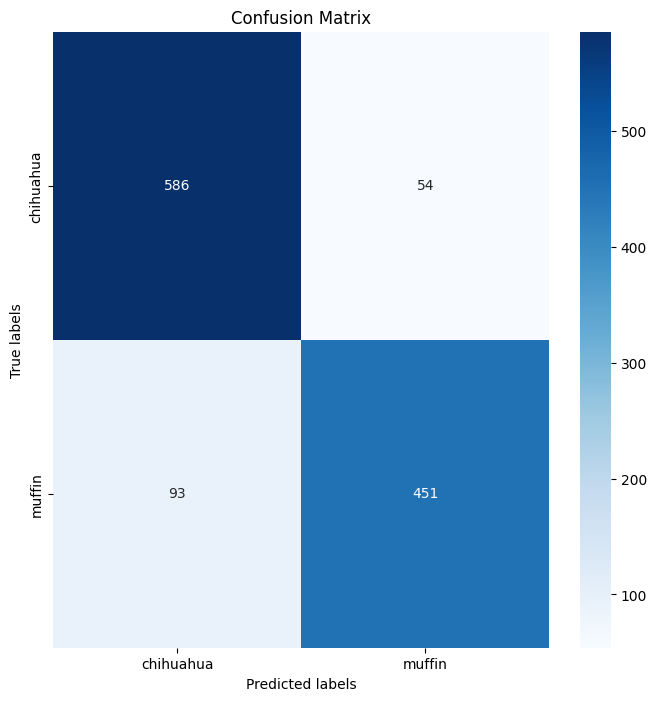

In [ ]:
predicted = np.round(predictions).astype(int)
matrix = confusion_matrix(test_labels,predicted)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['chihuahua', 'muffin'], yticklabels=['chihuahua', 'muffin'])
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

Let us test it on a picture from a friend!

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cane.jpeg to cane.jpeg


In [ ]:
from PIL import Image
import io

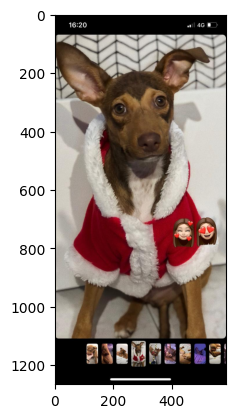

In [ ]:
uploaded_image_bytes = uploaded['cane.jpeg']
img = Image.open(io.BytesIO(uploaded_image_bytes))
plt.imshow(img)

In [ ]:
resize = tf.image.resize(img, (100, 100))

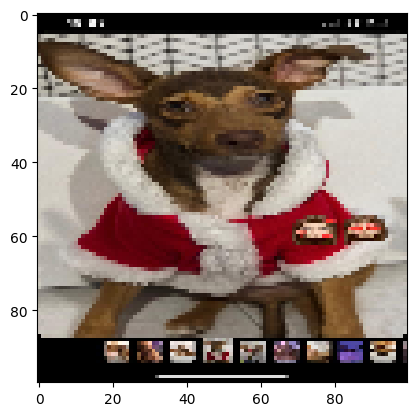

In [ ]:
plt.imshow(resize.numpy().astype(int))

In [ ]:
gray_img = tf.image.rgb_to_grayscale(resize)

In [ ]:
expe = model10.predict(np.expand_dims(gray_img/255, 0))

1/1 [==============================] - 0s 483ms/step


In [ ]:
expe

array([[9.0094414e-07]], dtype=float32)

The value is really close to 0 which in our case represents Chihuahuas proving that our model works.